In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 12

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

# for hierarchy part
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

# for additional visualization
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
colors = y
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

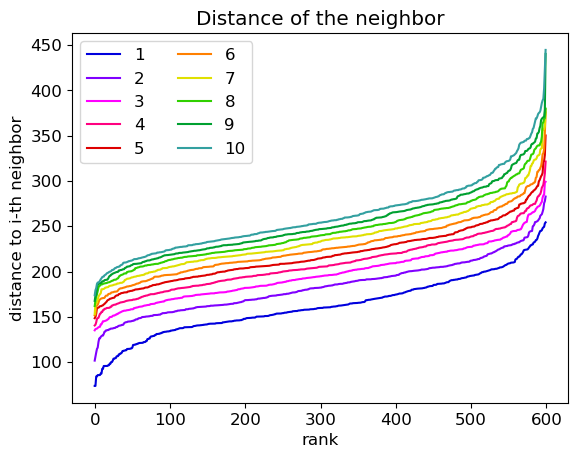

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.title("Distance of the neighbor")
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

## t-SNE visualization, for true labels

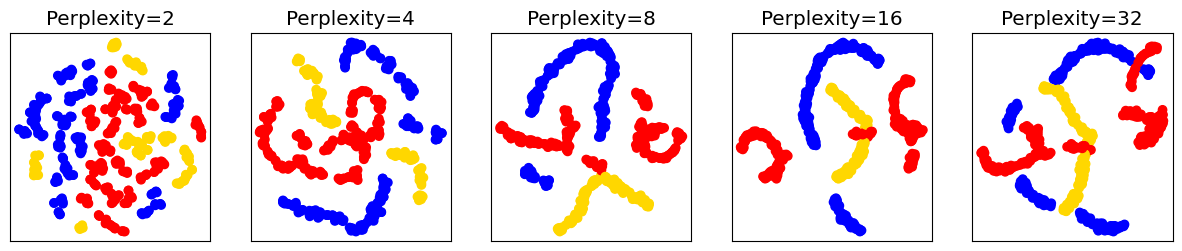

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

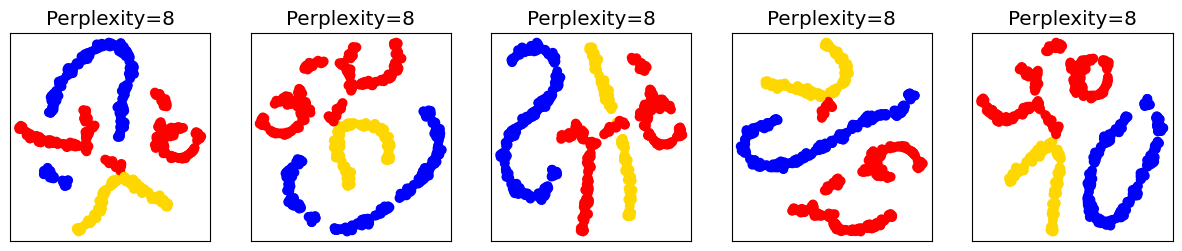

In [5]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

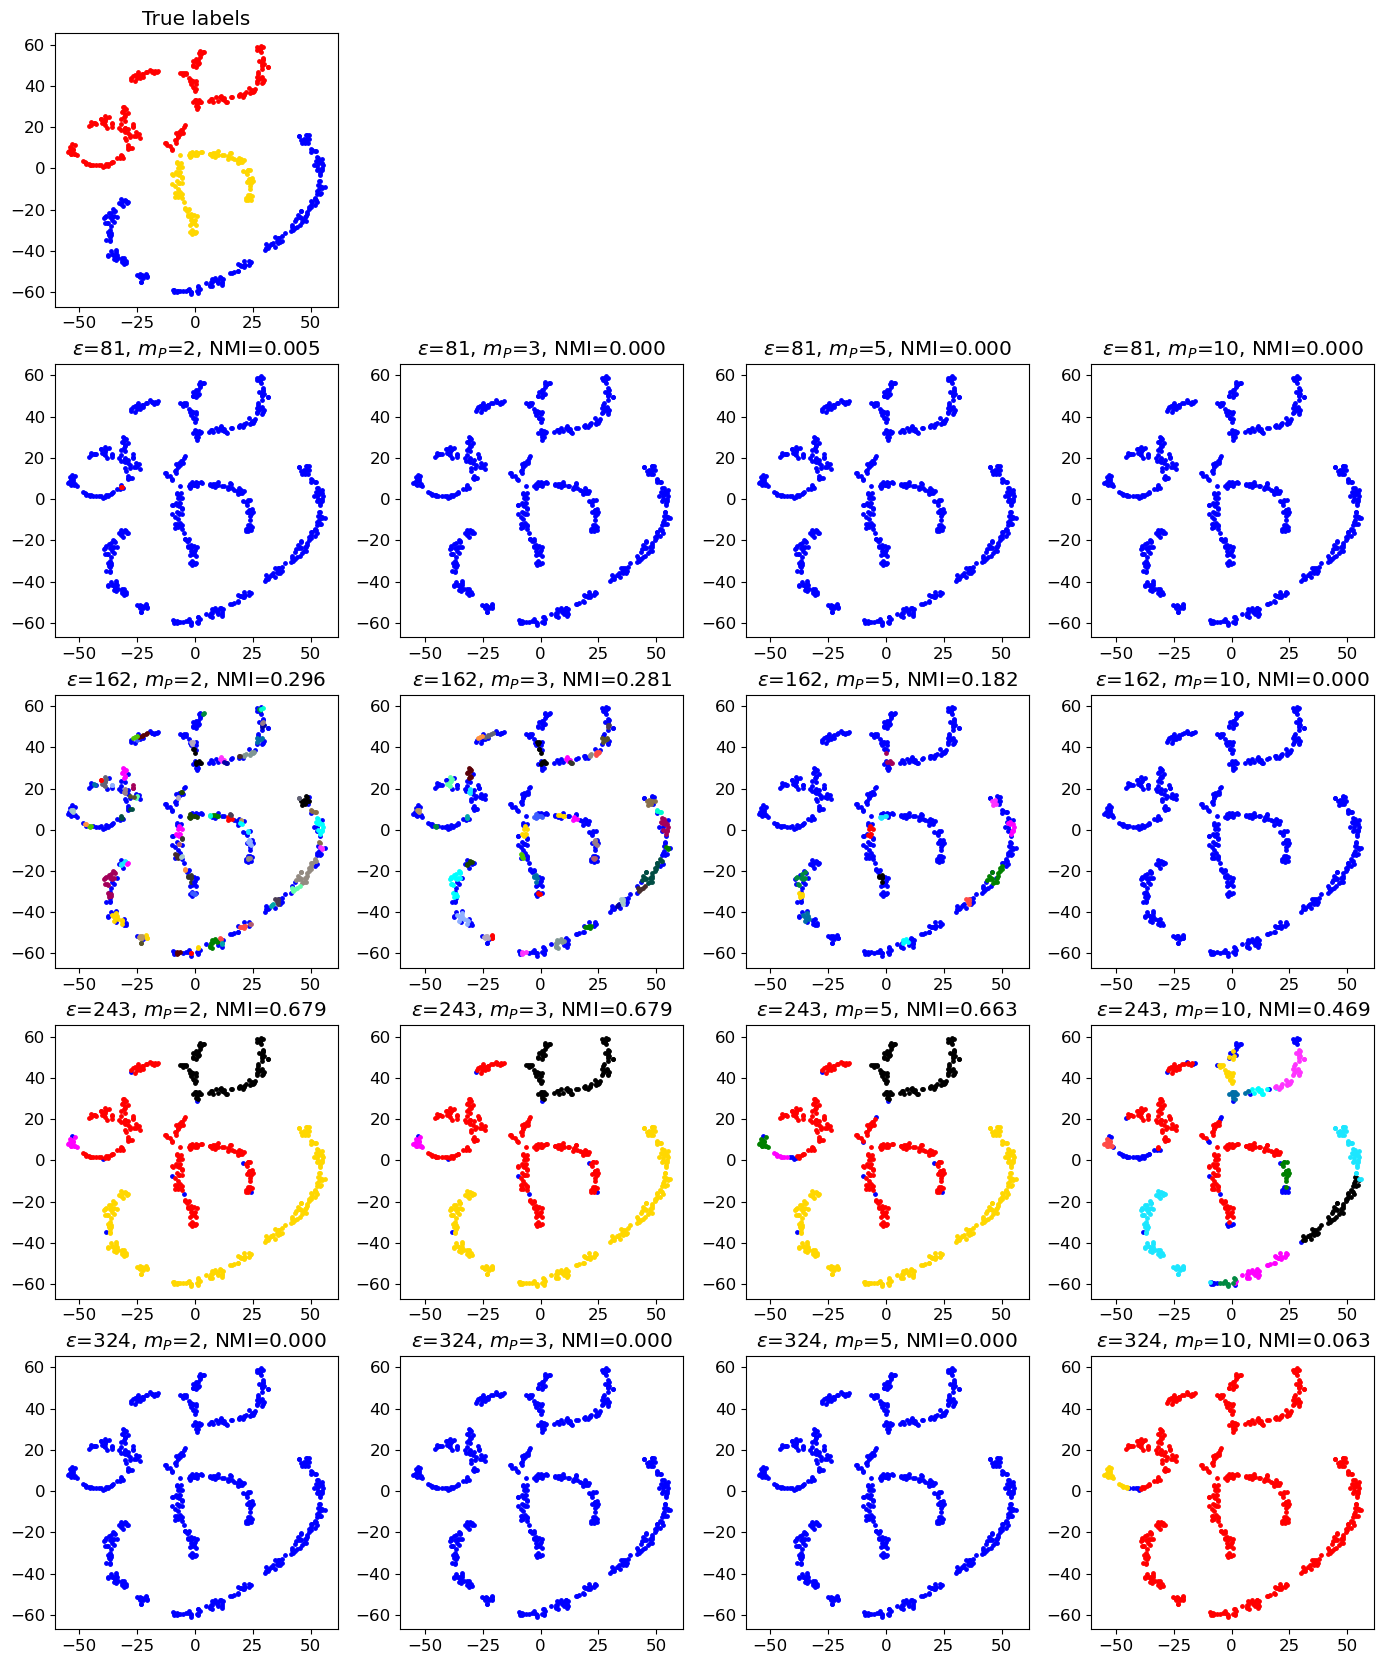

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax, colors=None, dimension1 = 0, dimension2 =1):
    # plotting function
    if colors==None:
        col = False
    else:
        col = True
        colors = np.array(colors)
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        if col == False:
            ax.scatter(X[pos,dimension1], X[pos,dimension2],c=cpalette[i%len(cpalette)],s=ms)
        else:
    
            ax.scatter(X[pos,dimension1], X[pos,dimension2],c=colors[pos],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]

min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(14,16.8))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()


# 1. “eps” (ε) and “minPts” (mP) in DBSCAN algorithm for clustering

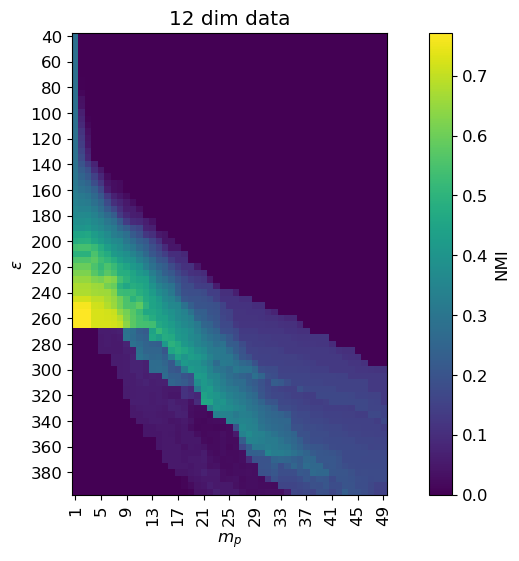

In [7]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3

# This is in the transformed space of t-SNE (see X_all) anche X_all[2] is the one bringing to the best visualization.
X2D = X_all[2]

#Former version, but it got just two dimensions note 3
#X3D = X_all[3]
# This is in the original dataset, nothing to do with X2D.
X3D = data[:,0:3]
X = data
y_true = y

if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = range(40,400,5)

min_sample_range = range(1,50)
DIMY=len(eps_range)
DIMX=len(min_sample_range)

i,j=0,0
nmi=1

nmi_array = []

for i, eps in enumerate(eps_range):
    nmi_row = []
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi=NMI(y_hat, y_true)
        nmi_row.append(nmi)
    nmi_array.append(nmi_row)

nmi_array = np.array(nmi_array)

plt.figure(figsize = (11,6))

plt.imshow(nmi_array, cmap='viridis', interpolation='nearest')

plt.colorbar(label="NMI", shrink= 1)
plt.yticks(range(len(eps_range)), labels=eps_range)
plt.xticks(range(len(min_sample_range)), labels=min_sample_range, rotation = 90)
xticks = plt.xticks()[0] 
yticks = plt.yticks()[0]

plt.xticks(xticks[::4])
plt.yticks(yticks[::4])

plt.ylabel(r"$\epsilon$")
plt.xlabel(r"$m_p$")
plt.grid(visible=False)
plt.title("12 dim data")
plt.show()

Looking at the map we can observe a correlation between the $\epsilon$ and the minimum number of neighboor ($m_p$) used to identify a cluster. In particular we can see that there is a region of high value of NMI for which appear a direct correlation between $m_p$ used to define the cluster and the dimension of the hyper-sphere of radious $\epsilon$.

This is coherent with results in plot _"Distance of the neighbor"_. We observe that the first 1 to 10 neighbors for the most data points are in a range between 160 and 260 as in the region with the highest NMI of the plot above.

# 2. Understanding the 12-dimensional data (PCA)

The 1° component given by PCA is the 1, it count for the 65.13% of the variability
The 2° component given by PCA is the 2, it count for the 27.66% of the variability
The 3° component given by PCA is the 3, it count for the 7.07% of the variability
The 4° component given by PCA is the 4, it count for the 0.07% of the variability
The 5° component given by PCA is the 5, it count for the 0.02% of the variability
The 6° component given by PCA is the 6, it count for the 0.02% of the variability
The 7° component given by PCA is the 7, it count for the 0.01% of the variability
The 8° component given by PCA is the 11, it count for the 0.01% of the variability
The 9° component given by PCA is the 10, it count for the 0.01% of the variability
The 10° component given by PCA is the 12, it count for the 0.00% of the variability
The 11° component given by PCA is the 9, it count for the 0.00% of the variability
The 12° component given by PCA is the 8, it count for the 0.00% of the variability




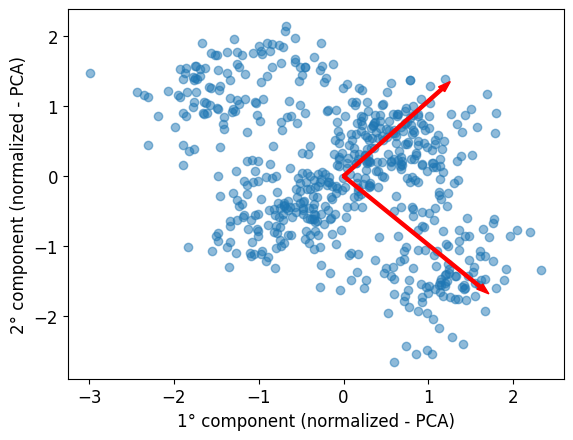

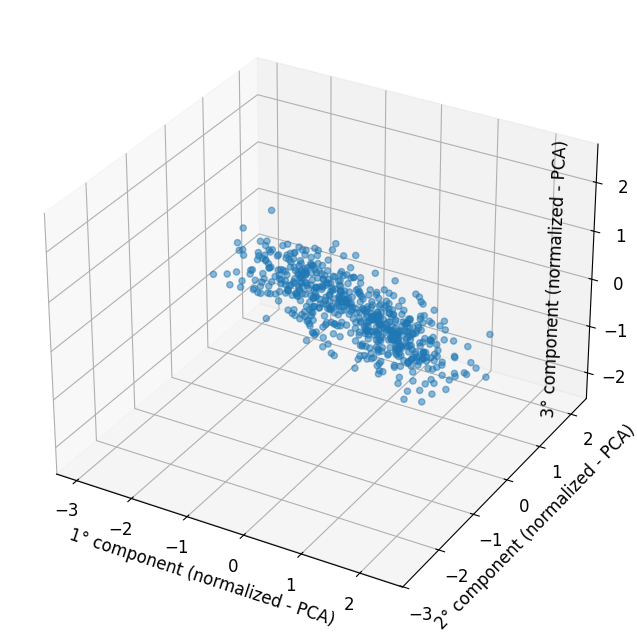

In [63]:
#Rescaling the data
me = np.mean(data,axis = 0)
dev = np.std(data,axis = 0)

data_sc = (data - me) / dev

C = np.cov(data_sc.T)

val, vec = np.linalg.eig(C)
sorted_indices = np.argsort(val)[::-1]
val = val[sorted_indices]
vec = vec[:, sorted_indices]

nrm = np.linalg.norm(val)**2

for i in range(len(val)):
    print(f"The {i+1}° component given by PCA is the {sorted_indices[i]+1}, it count for the {val[i]**2/nrm*100 :.2f}% of the variability")

plt.scatter(data_sc[:,sorted_indices[0]],data_sc[:,sorted_indices[1]], alpha=0.5)
factor = 200
for i in range(2):  # First two components
    plt.arrow(0, 0, vec[0, i] * val[i], vec[1, i] * val[i], color='red', width=0.04, head_width=0.1, alpha=1)

print("\n")
plt.xlabel("1° component (normalized - PCA)")
plt.ylabel("2° component (normalized - PCA)")
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_sc[:,sorted_indices[0]],data_sc[:,sorted_indices[1]], data_sc[:, sorted_indices[2]], alpha=0.5)

#for i in range(3):  # First two components
#    ax.quiver(0, 0, 0, vec[0, i] * val[i], vec[1, i] * val[i], vec[0,i]*val[i], color='red', linewidth=2, arrow_length_ratio=0.1+(0.2*i))#, width=0.04, head_width=0.1, alpha=1)

#ax.view_init(15, 65)
ax.set_xlabel("1° component (normalized - PCA)")
ax.set_ylabel("2° component (normalized - PCA)")
ax.set_zlabel("3° component (normalized - PCA)", labelpad=-37)
plt.show()

The PCA helps the understanding of the structure. In particular it shows that more than 99% of the variability is contained in the first 3 dimensions of the data. The remaining coordinates can be ingored. 

# 3. Compare with k-means

### Define k-means function

In [8]:
def kmeans(points: np.ndarray, k: int, max_iters: int = 50):
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # Generate random centroids
    # Use the correct means and standard deviation to ensure they represent the whole input space
    point_count = points.shape[0]
    coord_count = points.shape[1]
    data_means=[0]*coord_count
    data_devs=[0]*coord_count
    for coord in range(coord_count):
        data_means[coord] = np.mean(points[:,coord])
        data_devs[coord] = np.std(points[:,coord])

    centroids = np.ndarray((k,coord_count))
    for num_centroid in range(k):
        for coord in range(coord_count):
            centroids[num_centroid, coord] = np.random.normal(data_means[coord], data_devs[coord])

    clusters = np.ndarray((point_count,))
    
    prev_error = 1e9+1
    error = [1e9]
    
    # Iterate until the estimate of centroid is stable (or the maximum number of iterations is reached)
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:
        # Measure the distance to every centroid
        distances = np.ndarray((point_count,k))
        for point_num in range(point_count):
            for centroid_num in range(k):
                distances[point_num, centroid_num]=np.linalg.norm(points[point_num]-centroids[centroid_num])

        # Step 1: assign training data to closest centroid
        for point_num in range(point_count):
            clusters[point_num] = np.argmin(distances[point_num])
       
        # Calculate barycenter for every cluster and update the centroid
        for centroid_num in range(k):
            for coord_num in range(coord_count):
                sum_for_avg = 0
                count_for_avg = 0
                for point_num in range(point_count):
                    if(clusters[point_num] == centroid_num):
                        count_for_avg += 1
                        sum_for_avg += points[point_num, coord_num]
                #max is here to avoid sporadic "division by 0" errors
                centroids[centroid_num, coord_num] = sum_for_avg/np.max([count_for_avg, 1]) 
               
        
        # Update the error
        prev_error = error[iters]
        current_error = 0 # average L2 loss
        for point_num in range(point_count):
            distances = [0]*coord_count
            for coord_num in range(coord_count):
                distances[coord_num] = points[point_num, coord_num] - centroids[int(clusters[point_num]), coord_num]
            current_error+=np.sum(np.square(distances))
        current_error /= point_count
        error.append(current_error)
        
        # Update the iteration counter
        iters += 1

    return centroids, clusters, error

### Applyed to all 12 dimensions (3 clusters)

In [107]:
_, y_k_means, _ = kmeans(data, k=3, max_iters = 50)

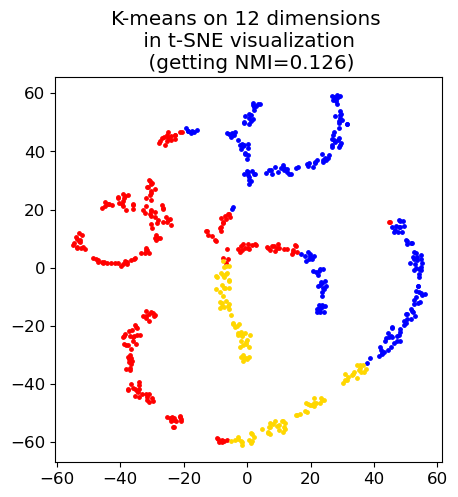

In [108]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

plotting_ax(X2D,y_k_means,ax)
nmi_k_means=NMI(y_k_means, y_true)
ax.set_title(f'K-means on 12 dimensions \n in t-SNE visualization \n (getting NMI={nmi_k_means:.3f})')
plt.show()

### Applied just to the 3 main dimensions (3 clusters)

In [109]:
centroids , y_k_means3D, _ = kmeans(X3D, k=3, max_iters = 50)

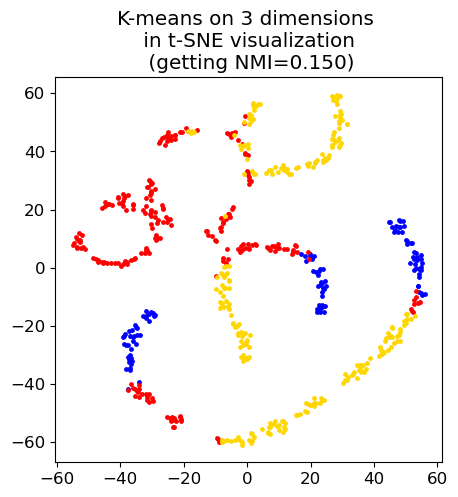

In [110]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
plotting_ax(X2D,y_k_means3D,ax)
nmi_k_means3D=NMI(y_k_means3D, y_true)
ax.set_title(f'K-means on 3 dimensions \n in t-SNE visualization \n (getting NMI={nmi_k_means3D:.3f})')
plt.show()

Starting from 12 or just the 3 main dimensions produce almost the same results, as it can been seen from the t-SNE visualization and the NMI scores, this result supports what already said in the PCA analysis. 

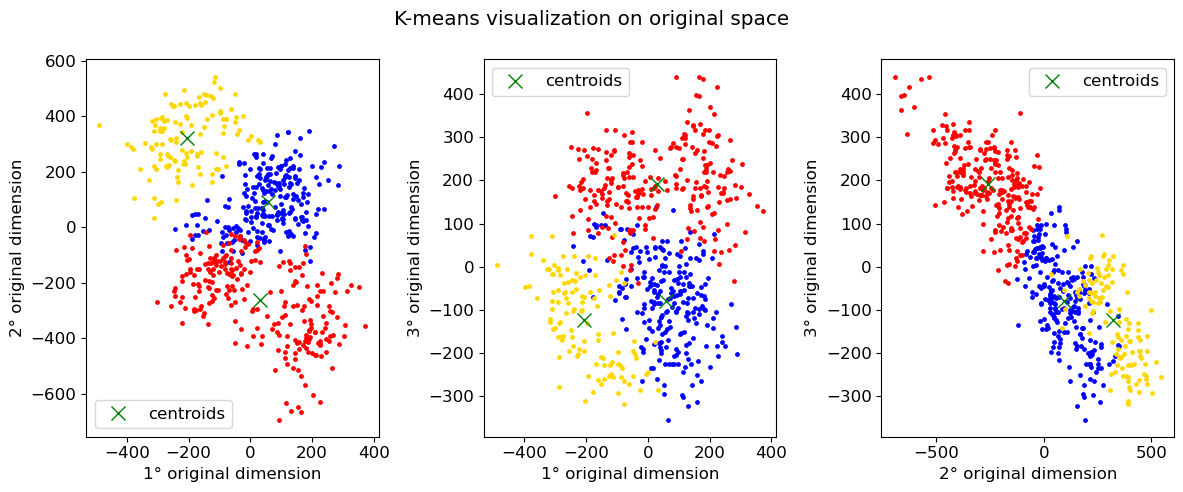

In [82]:
fig, axes = plt.subplots(1,3,figsize=(12,5))
plt.suptitle("K-means visualization on original space")
proj = [ [0,1],[0,2],[1,2] ]
for e,pro in enumerate(proj):
    a,b = pro
    plotting_ax(X3D,y_k_means3D,axes[e],dimension1=a,dimension2=b)
    axes[e].plot(centroids[:,a],centroids[:,b],"x",color="green",markersize=10,label="centroids")
    axes[e].legend(loc='best')
    axes[e].set_xlabel(f"{a+1}° original dimension")
    axes[e].set_ylabel(f"{b+1}° original dimension")
    plt.tight_layout()
plt.show()

### Results with general number of clusters

In [16]:
# Computartional parallelized version
import concurrent.futures
from tqdm import tqdm

def compute_nmi(n):
    """KMeans on 12 and 3 dimensions and then compute NMI."""
    _, y_k_means, _ = kmeans(data, k=n, max_iters=200)
    nmi_val = NMI(y_k_means, y_true)

    _, y_k_means3D, _ = kmeans(X3D, k=n, max_iters=200)
    nmi_3D_val = NMI(y_k_means3D, y_true)

    return n, nmi_val, nmi_3D_val

N = 200
nmi_com = []
nmi_3D = []

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(compute_nmi, range(1, N)), total=N-1))

# Reorder result base on N, number of clusters
results.sort()  
nmi_com = [res[1] for res in results]
nmi_3D = [res[2] for res in results]

100%|█████████████████████████████████████████| 199/199 [02:05<00:00,  1.59it/s]


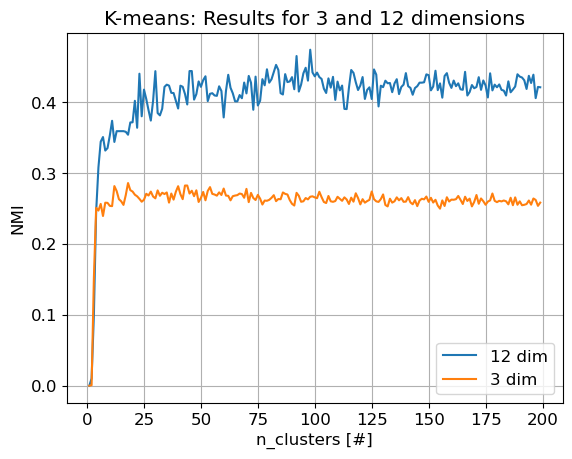

In [18]:
'''
#Computationaly takes time
N = 200
nmi_com = []
nmi_3D = []
for n in range(1,N):
    _ , y_k_means, _   = kmeans(data, k=n, max_iters = 50)
    nmi_com.append(  NMI(y_k_means, y_true)  )
    _ , y_k_means3D, _ = kmeans(X3D, k=n, max_iters = 50)
    nmi_3D.append(   NMI(y_k_means3D, y_true)  )
'''

plt.plot(range(1,N),nmi_com, label = "12 dim")
plt.plot(range(1,N),nmi_3D, label = "3 dim")
plt.xlabel("n_clusters [#]")
plt.ylabel("NMI")
plt.title("K-means: Results for 3 and 12 dimensions")
plt.grid()
plt.legend(loc="best")

plt.show()

We had runned K-means algorithm both in all 12 dimensions of the input dataset, and in the 3 main dimensions given by the PCA. <br>
Since the data are not well separated with respect to the classic euclidian distances, K-means doesn't perform so well in the clustering task both considering all coordinates or just the main 3. <br>
The worst result is clearly visible by looking at the plots in the t-SNE visualization and by the lowers NMI scores obtained respect to the best produced by DBSCAN.

# 4. Hierarchical clustering

### Define the Hierarchical function

In [83]:
def hierarc(dataset, n_clusters, linkage, plot_dendr=False):

    # To standardize data
    #scaler = StandardScaler()
    #data = scaler.fit_transform(data)

    hc = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    y_hierar = hc.fit_predict(dataset)

    if plot_dendr:
        plt.figure(figsize=(8, 6))
        linkage_matrix = sch.linkage(data, method=linkage)
        dendrogram = sch.dendrogram(linkage_matrix, color_threshold=linkage_matrix[-(n_clusters-1), 2])
        plt.title(f"Dendogram of Hierarchical Clustering")
        plt.xlabel("Index of data")
        plt.ylabel("Distance")
        plt.tick_params(       # to remove the x ticks, we used the following settings
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        plt.show()

        # following part just to be consistent with choice of the colors for the clusters
        '''
        cluster_colors = {}
        i = 0
        for label, color in zip(dendrogram['leaves'], dendrogram['leaves_color_list']):
            if label not in cluster_colors:
                cluster_colors[label] = color
        i += 1
        point_colors = [cluster_colors[label] for label in labels]
        '''
        leaf_colors = {}
        for leaf, color in zip(dendrogram['leaves'], dendrogram['leaves_color_list']):
            leaf_colors[leaf] = color
        point_colors = [leaf_colors[i] for i in range(len(dataset))]
    
        return y_hierar, point_colors
    return y_hierar

### Applyed to all 12 dimensions

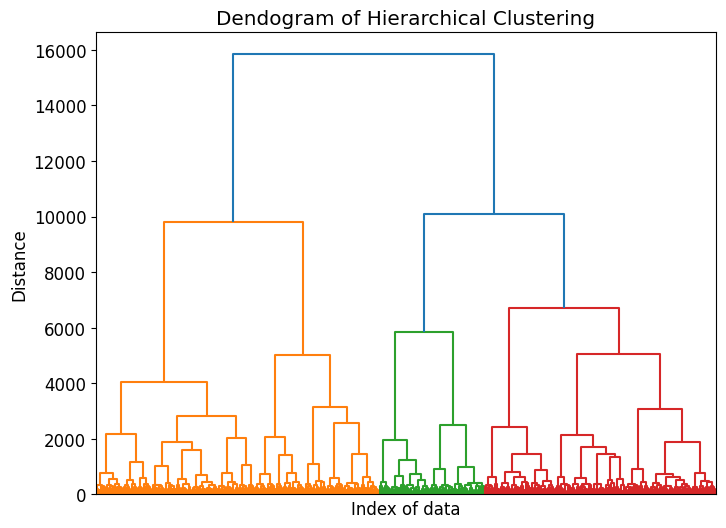

In [70]:
hierar_num_clust = 3
y_hierar, clusters_colors_hier = hierarc(dataset=data, n_clusters=hierar_num_clust, linkage='ward', plot_dendr=True)

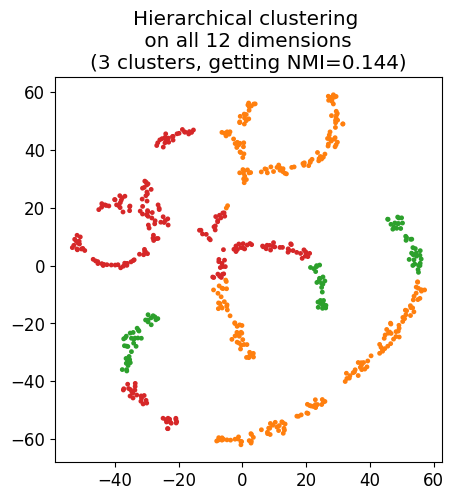

In [71]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

plotting_ax(X2D,y_hierar,ax,clusters_colors_hier)

nmi_hierar=NMI(y_hierar, y_true)
ax.set_title(f'Hierarchical clustering \n on all 12 dimensions \n({hierar_num_clust} clusters, getting NMI={nmi_hierar:.3f})')
plt.show()

### Applied just to the 3 main dimensions

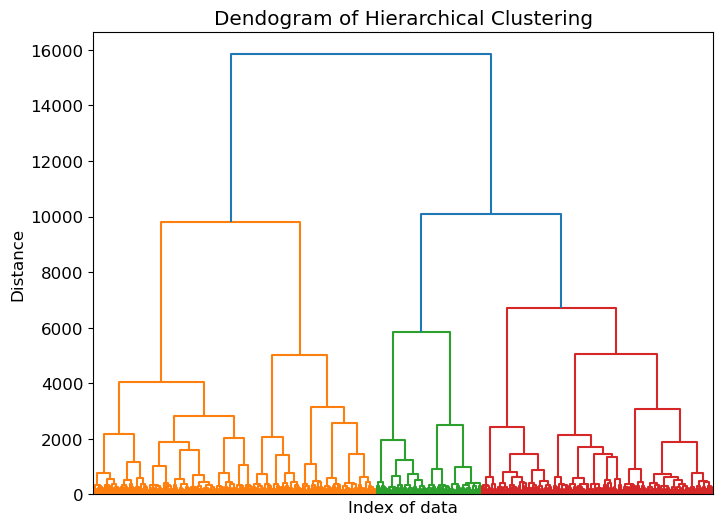

In [84]:
hierar_num_clust3D = 3
y_hierar3D, clusters_colors_hier3D = hierarc(dataset=X3D, n_clusters=hierar_num_clust3D, linkage='ward', plot_dendr=True)

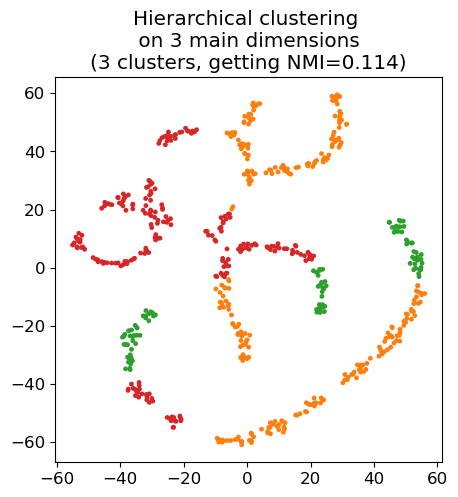

In [85]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

plotting_ax(X2D,y_hierar3D,ax,clusters_colors_hier3D)

nmi_hierar3D=NMI(y_hierar3D, y_true)
ax.set_title(f'Hierarchical clustering \n on 3 main dimensions \n({hierar_num_clust3D} clusters, getting NMI={nmi_hierar3D:.3f})')
plt.show()

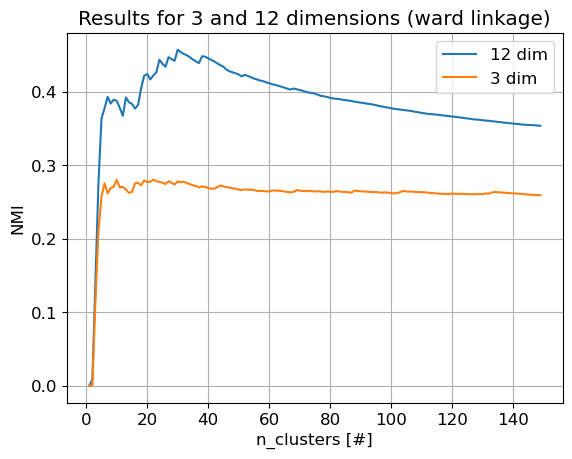

In [86]:
N = 150

nmi_com = []
nmi_3D = []

for n in range(1,N):
    y_hierar = hierarc(dataset=data, n_clusters=n, linkage='ward', plot_dendr=0)
    nmi_hierar = NMI(y_hierar, y_true)
    nmi_com.append(nmi_hierar)
    y_hierar3D = hierarc(dataset=X3D, n_clusters=n, linkage='ward', plot_dendr=0)
    nmi_hierar3D = NMI(y_hierar3D, y_true)
    nmi_3D.append(nmi_hierar3D)

plt.plot(range(1,N),nmi_com, label = "12 dim")
plt.plot(range(1,N),nmi_3D, label = "3 dim")
plt.xlabel("n_clusters [#]")
plt.ylabel("NMI")
plt.title("Results for 3 and 12 dimensions (ward linkage)")
plt.grid()
plt.legend(loc="best")

plt.show()

### Different type of linkages

We use all the possible linkages given by scipy and perform the analysis for both 3 and 12 dimensions.

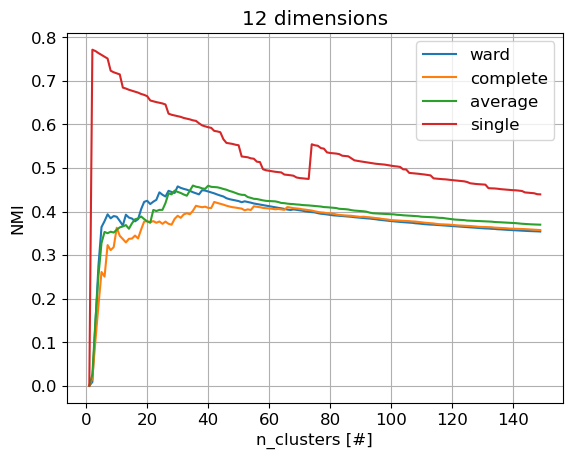

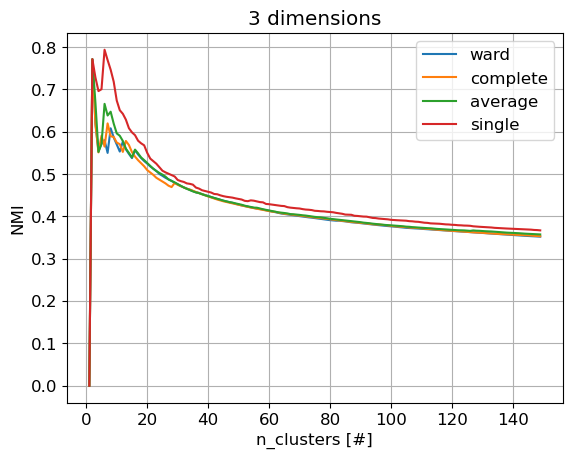

In [92]:
N = 150

linkage_a = ['ward', 'complete', 'average', 'single']

for linkage in linkage_a:
    nmi_com = []
    
    for n in range(1,N):
        y_hierar = hierarc(dataset=data, n_clusters=n, linkage=linkage, plot_dendr=0)
        nmi_hierar = NMI(y_hierar, y_true)
        nmi_com.append(nmi_hierar)
    
    plt.plot(range(1,N),nmi_com, label = f"{linkage}")

plt.title("12 dimensions")
plt.xlabel("n_clusters [#]")
plt.ylabel("NMI")
plt.grid()
plt.legend(loc="best")

plt.show()


for linkage in linkage_a:
    nmi_3D = []
    
    for n in range(1,N):
        y_hierar3D = hierarc(dataset=X3D, n_clusters=n, linkage=linkage, plot_dendr=0)
        nmi_hierar3D = NMI(y_hierar3D, y_true)
        nmi_3D.append(nmi_hierar3D)
    
    #plt.plot(range(1,N),nmi_com, label = f"{linkage}")
    plt.plot(range(1,N),nmi_3D, label = f"{linkage}")

plt.title("3 dimensions")
plt.xlabel("n_clusters [#]")
plt.ylabel("NMI")
plt.grid()
plt.legend(loc="best")

plt.show()

We can see that for our data the type of linkage "single" performs consistently better than the other methods in th regarding the number of clusters.\
In single linkage hierarchical clustering, the distance between two clusters is the minimum distance between any two points across the clusters.
And at its peak of performance hierarchical clustering works better than k-means.

# 5. Visualize the data

In [88]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt

import numpy as np
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

from sklearn.manifold import LocallyLinearEmbedding

mycmap = ListedColormap(["blue","red","gold" ])

In [77]:
def Visual_maps(n_neighbors, data = data, colors = colors, vis_3D = 0, print_out = 0):

    n_samples = len(data[:,0])
    #Build the data structure in 3D

    fig = plt.figure(figsize=(15, 4.5*(2+vis_3D)))
    plt.suptitle( "Manifold Learning with %i neighbors" %n_neighbors, fontsize=14 )
    
    if vis_3D:
        for i in range(2):
            ax = fig.add_subplot(3,2,i+1,projection='3d')
            ax.scatter(data[:,0], data[:,1], data[:,2], c=colors, s=5, cmap=mycmap, depthshade=True)
            ax.view_init(25+15*i*0.8, 45*(i-1))       
            plt.draw()

    D3_data = np.array([data[:,0], data[:,1], data[:,2]]).T
    
    # Perform Locally Linear Embedding Manifold learning
    methods = ["standard", "ltsa", "hessian", "modified"]
    labels = ["LLE", "LTSA", "Hessian LLE", "Modified LLE"]
    
    for i, method in enumerate(methods):
        t0 = time()
        trans_data = (
            manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method=method, random_state=42, eigen_solver='dense')
            .fit_transform(D3_data)
            .T
        )
        t1 = time()
        if print_out:
            print("%s: %.2g sec" % (methods[i], t1 - t0))
    
        ax = fig.add_subplot(2+vis_3D, 4, 1+4*vis_3D + i)
        plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=mycmap)
        plt.title(labels[i])
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis("tight")
    
    # Perform Isomap Manifold learning.
    t0 = time()
    trans_data = (
        manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
        .fit_transform(D3_data)
        .T
    )
    t1 = time()
    if print_out:
        print("ISO: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(2+vis_3D, 4, 5+4*vis_3D)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=mycmap)
    plt.title("Isomap")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")
    
    # Perform Multi-dimensional scaling.
    t0 = time()
    mds = manifold.MDS(2, max_iter=100, n_init=1, random_state=42)
    trans_data = mds.fit_transform(D3_data).T
    t1 = time()
    if print_out:
        print("MDS: %.2g sec" % (t1 - t0))
    
    ax = fig.add_subplot(2+vis_3D, 4, 6+4*vis_3D)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=mycmap)
    plt.title("MDS")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")
    
    # Perform Spectral Embedding.
    t0 = time()
    se = manifold.SpectralEmbedding(
        n_components=2, n_neighbors=n_neighbors, random_state=42
    )
    trans_data = se.fit_transform(D3_data).T
    t1 = time()
    if print_out:
        print("Spectral Embedding: %.2g sec" % (t1 - t0))
    
    ax = fig.add_subplot(2+vis_3D, 4, 7+4*vis_3D)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=mycmap)
    plt.title("Spectral Embedding")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")
    
    # Perform t-distributed stochastic neighbor embedding.
    t0 = time()
    tsne = manifold.TSNE(n_components=2, random_state=0)
    trans_data = tsne.fit_transform(D3_data).T
    t1 = time()
    if print_out:
        print("t-SNE: %.2g sec" % (t1 - t0))
    
    ax = fig.add_subplot(2+vis_3D, 4, 8+4*vis_3D)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=mycmap)
    plt.title("t-SNE")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")
    
    plt.show()

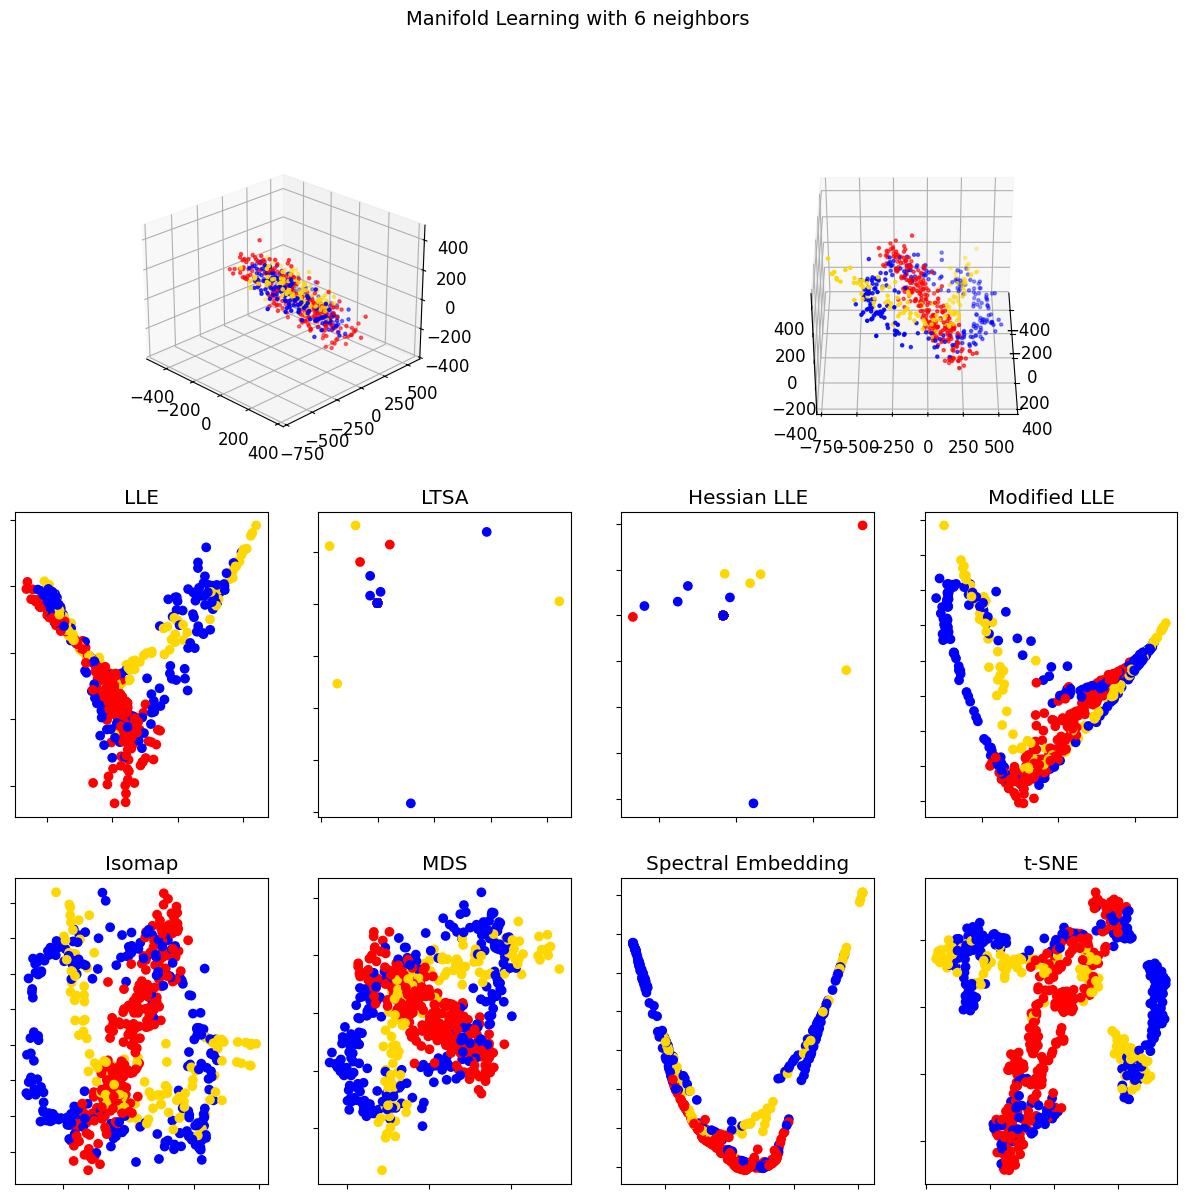

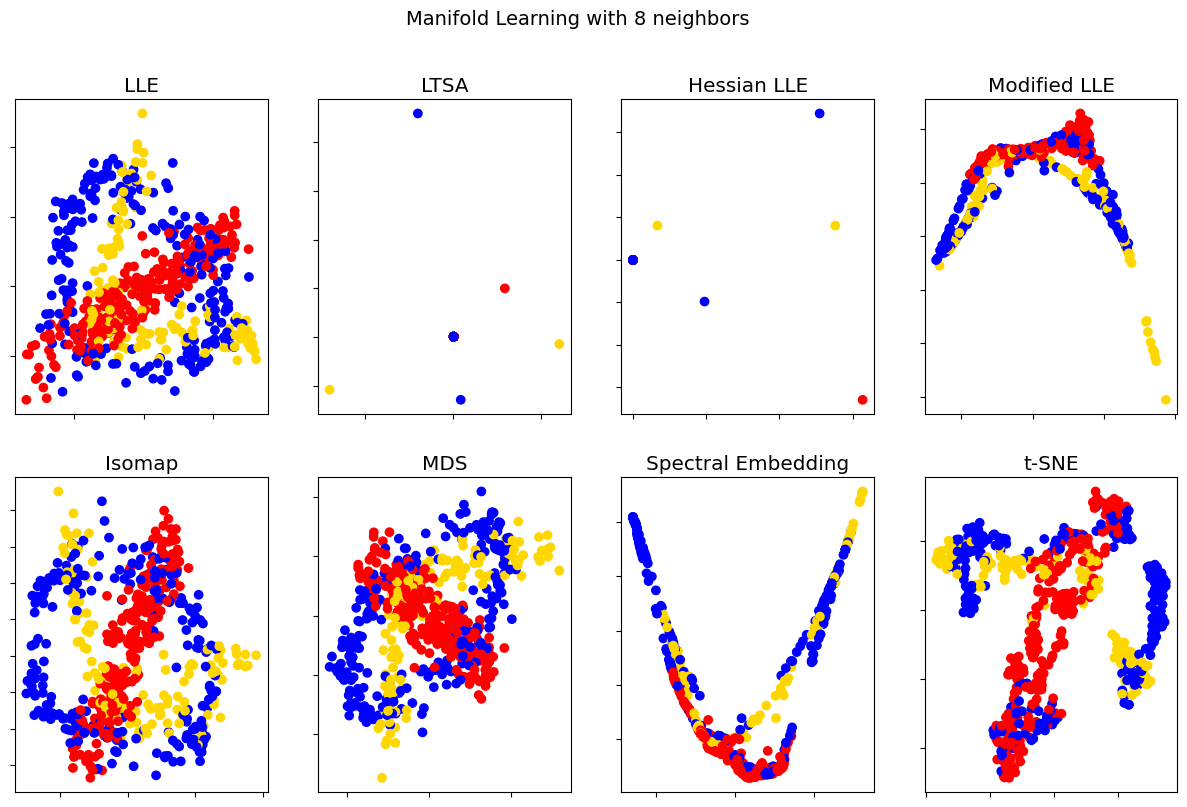

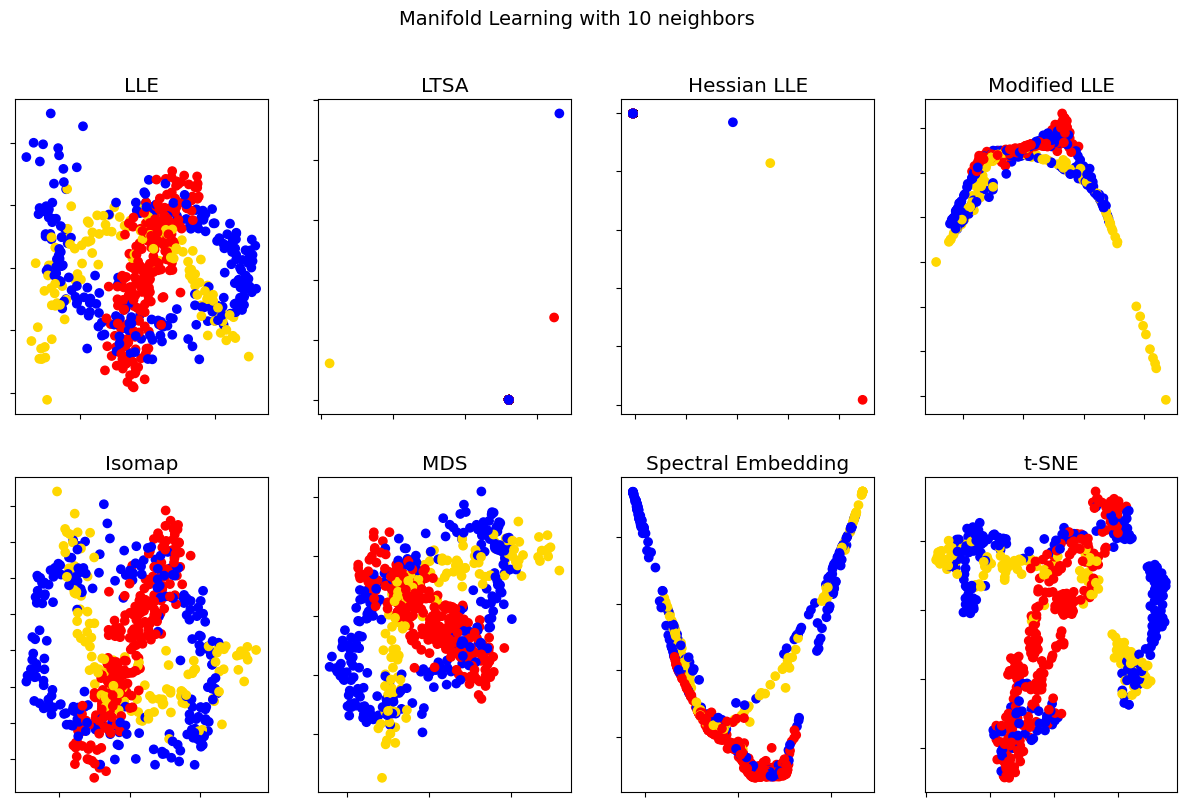

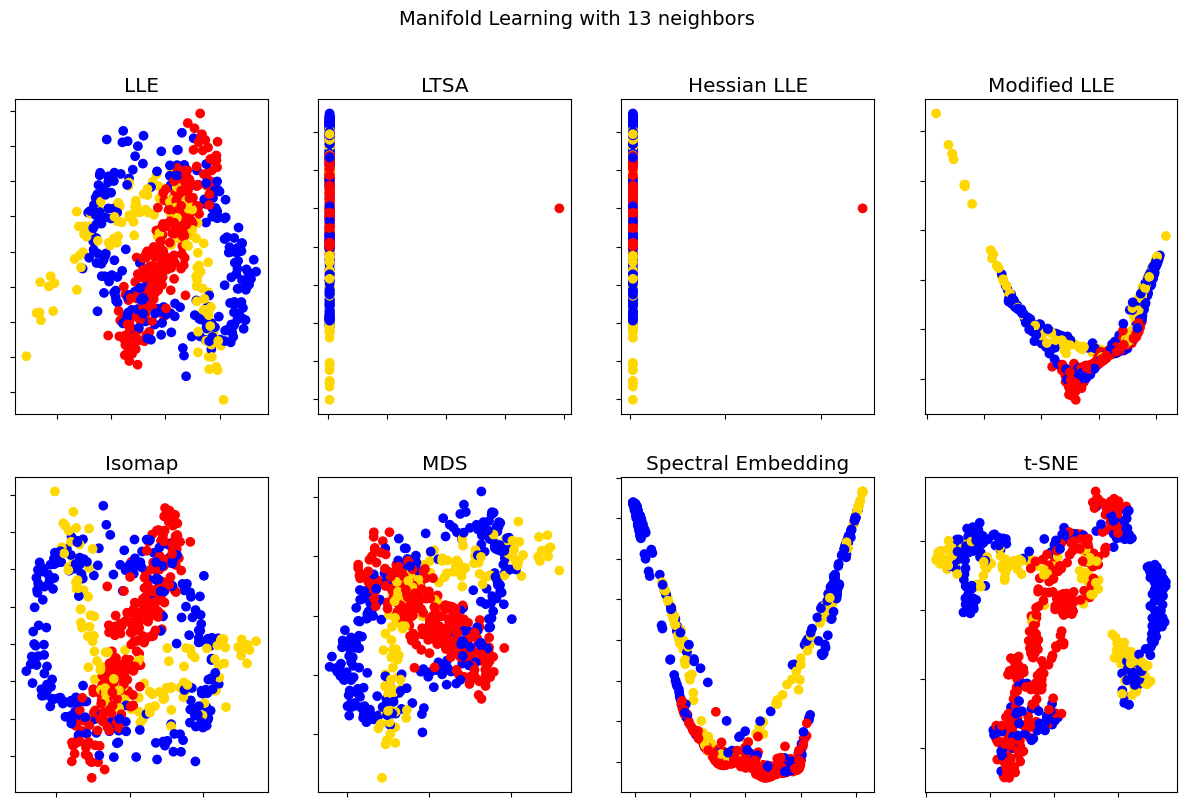

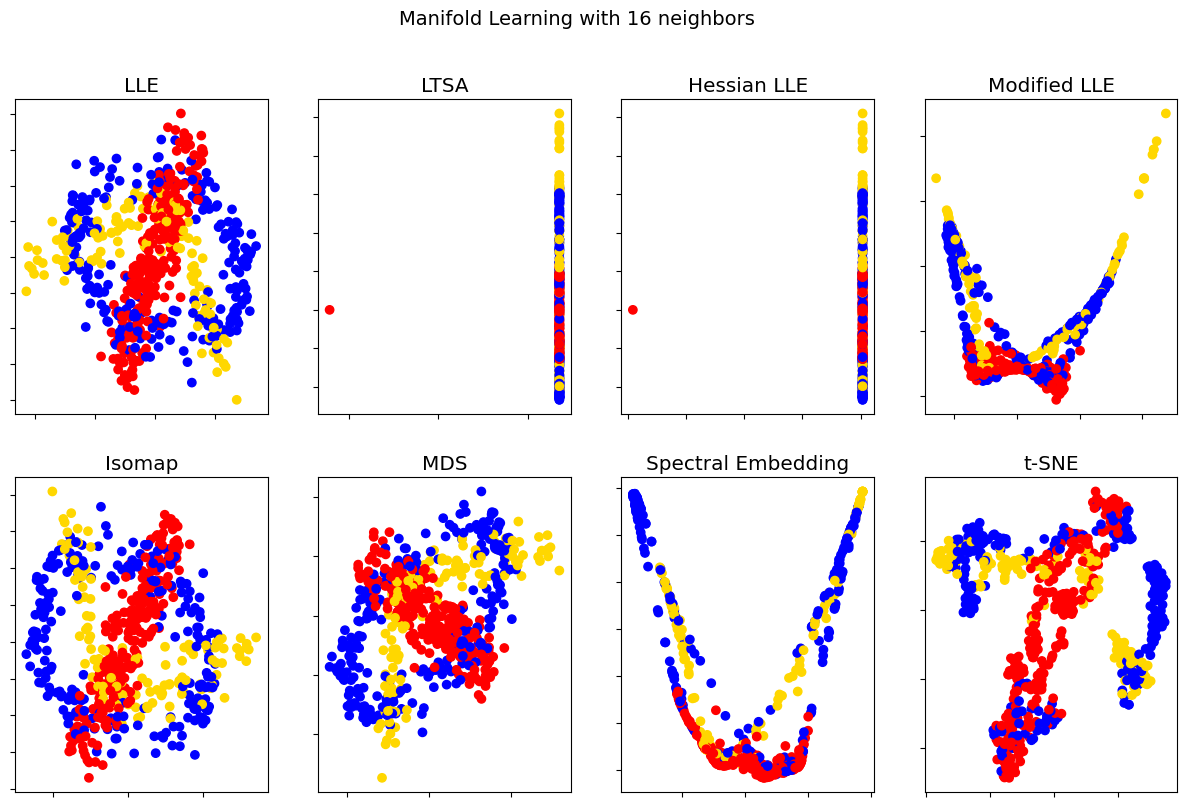

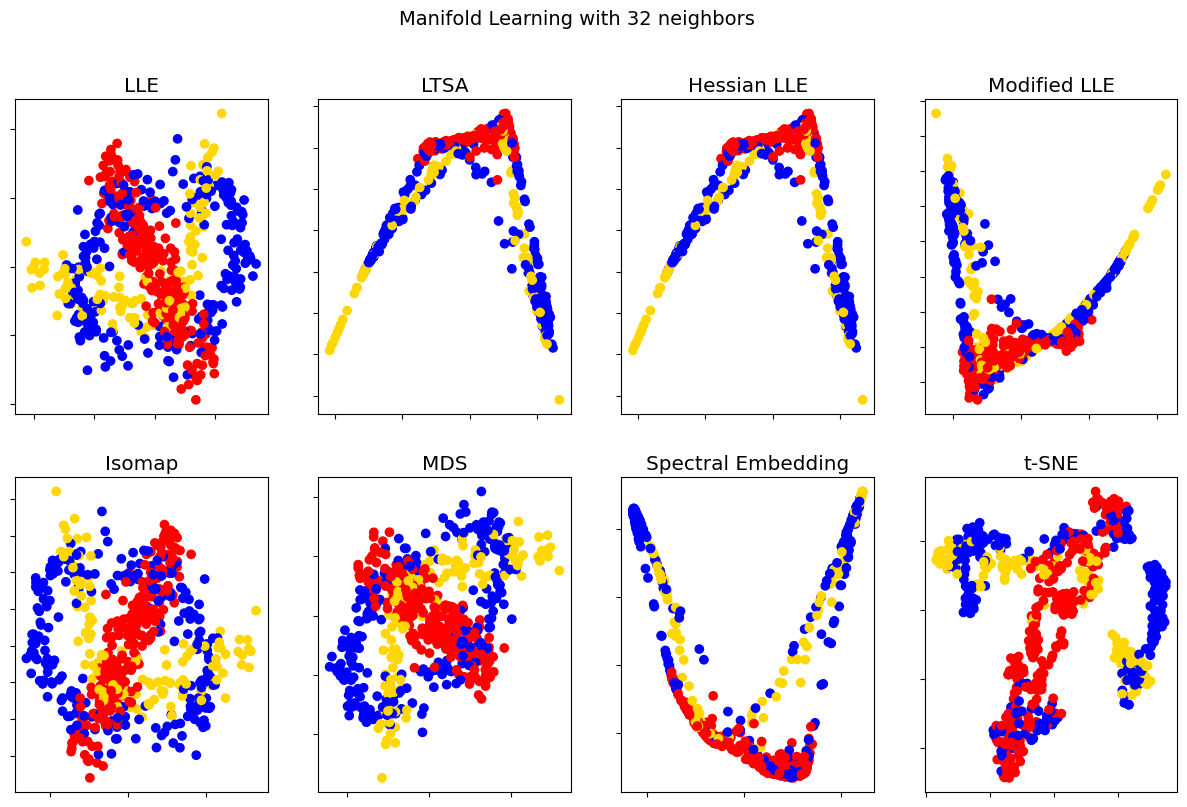

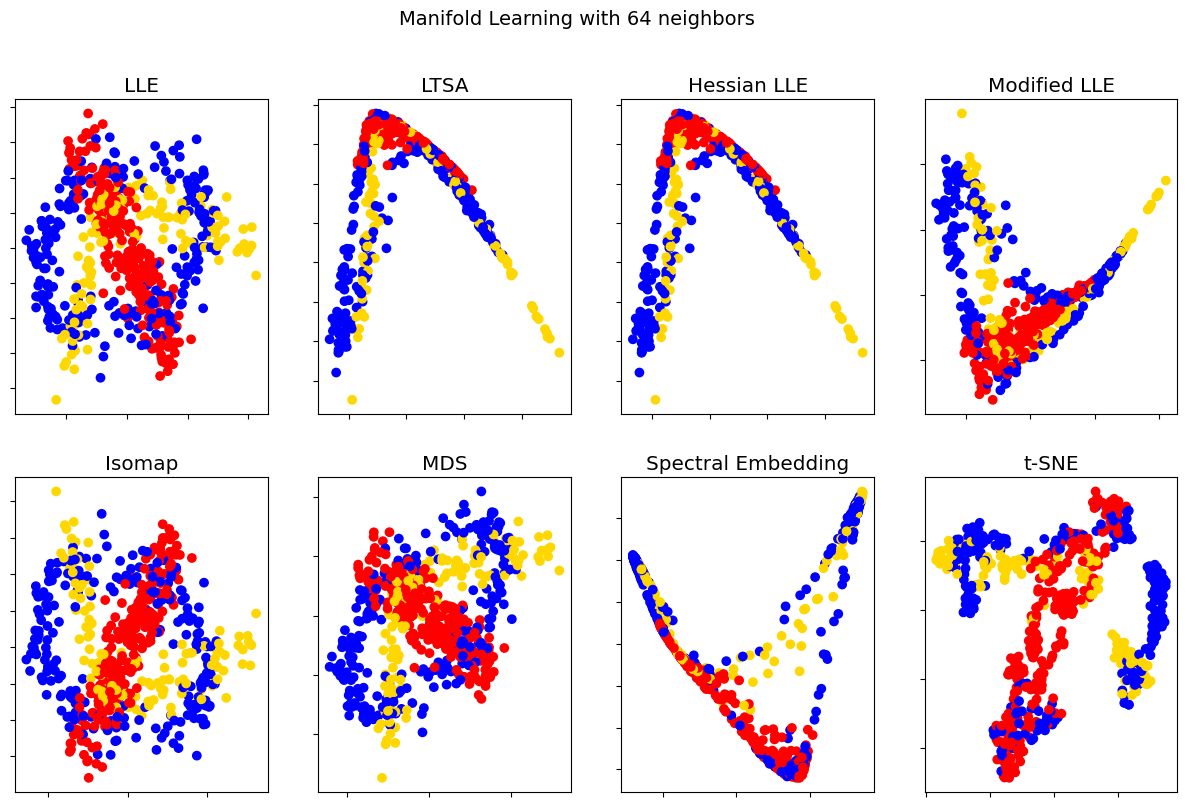

In [78]:
neighbors_list = [6, 8, 10, 13, 16, 32, 64]
k = 1
for n in neighbors_list:
    Visual_maps(n, vis_3D=k)
    k = 0

### Test with not noise data 

/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


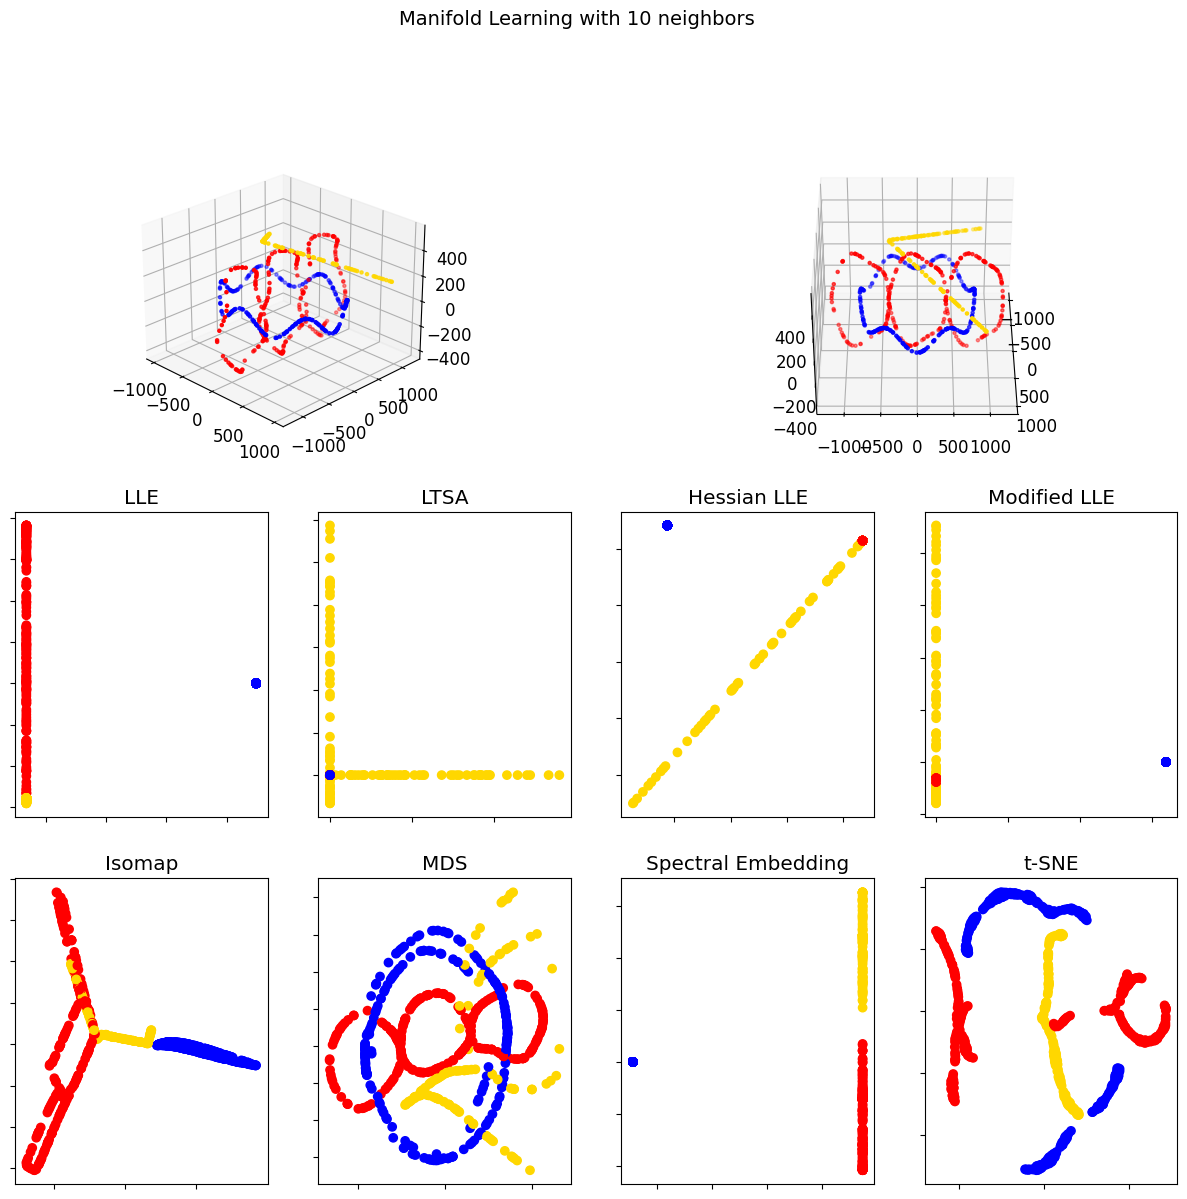

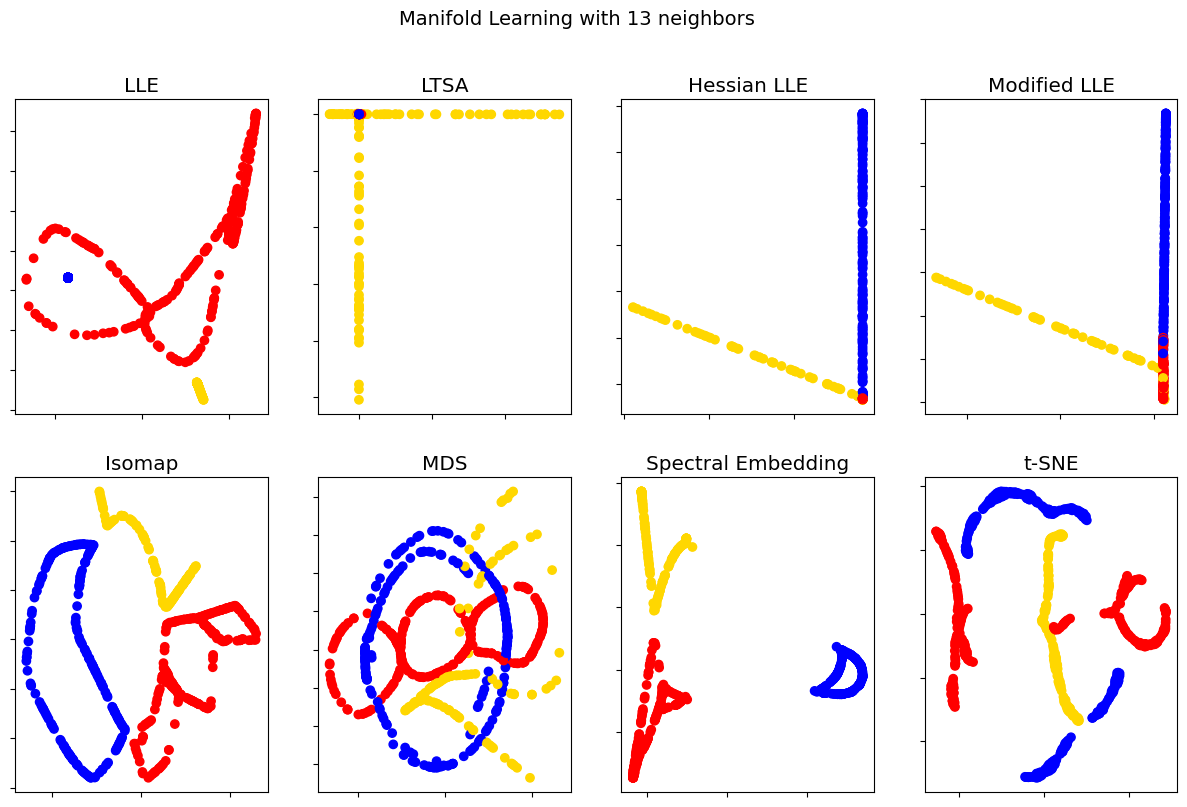

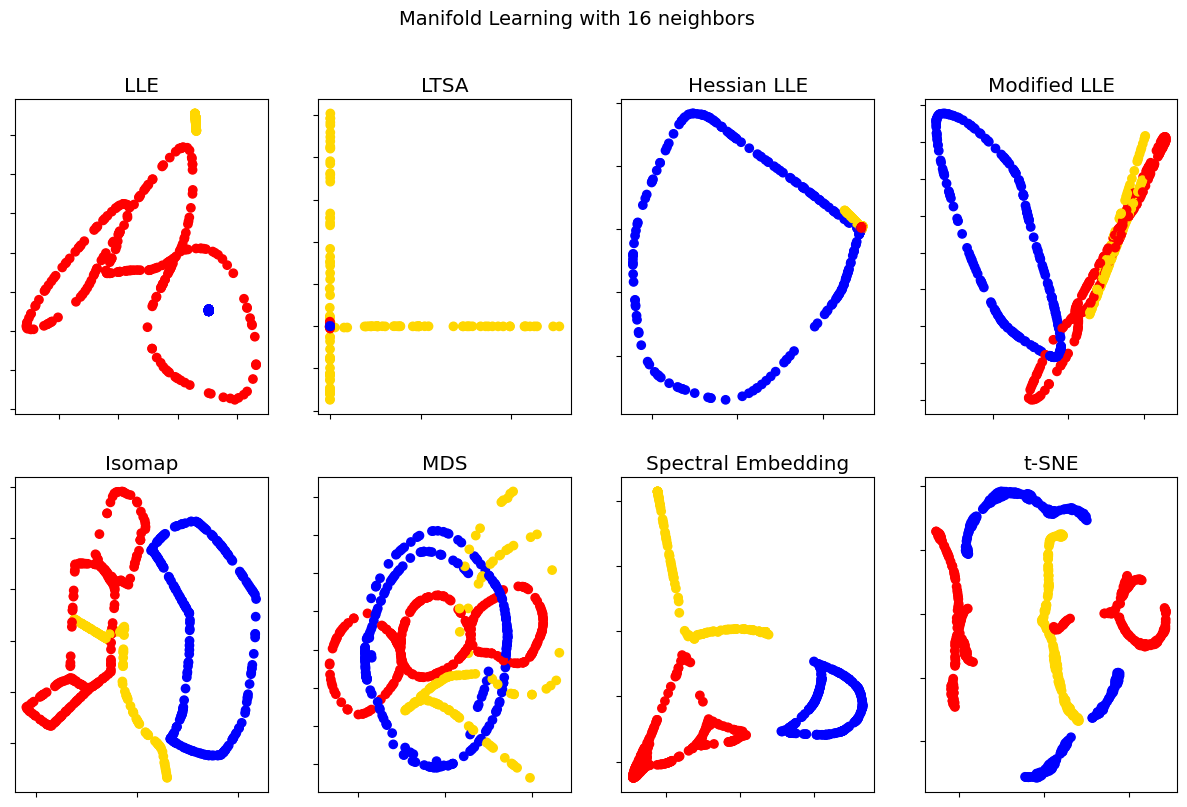

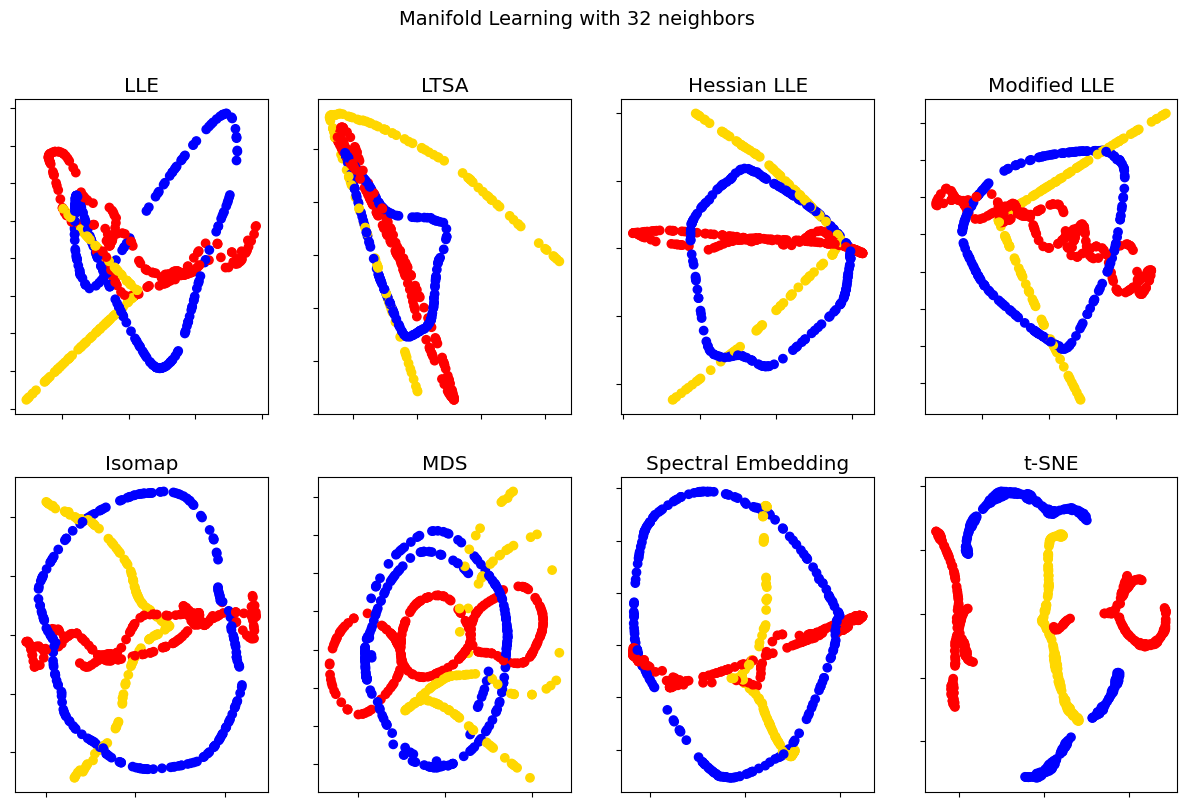

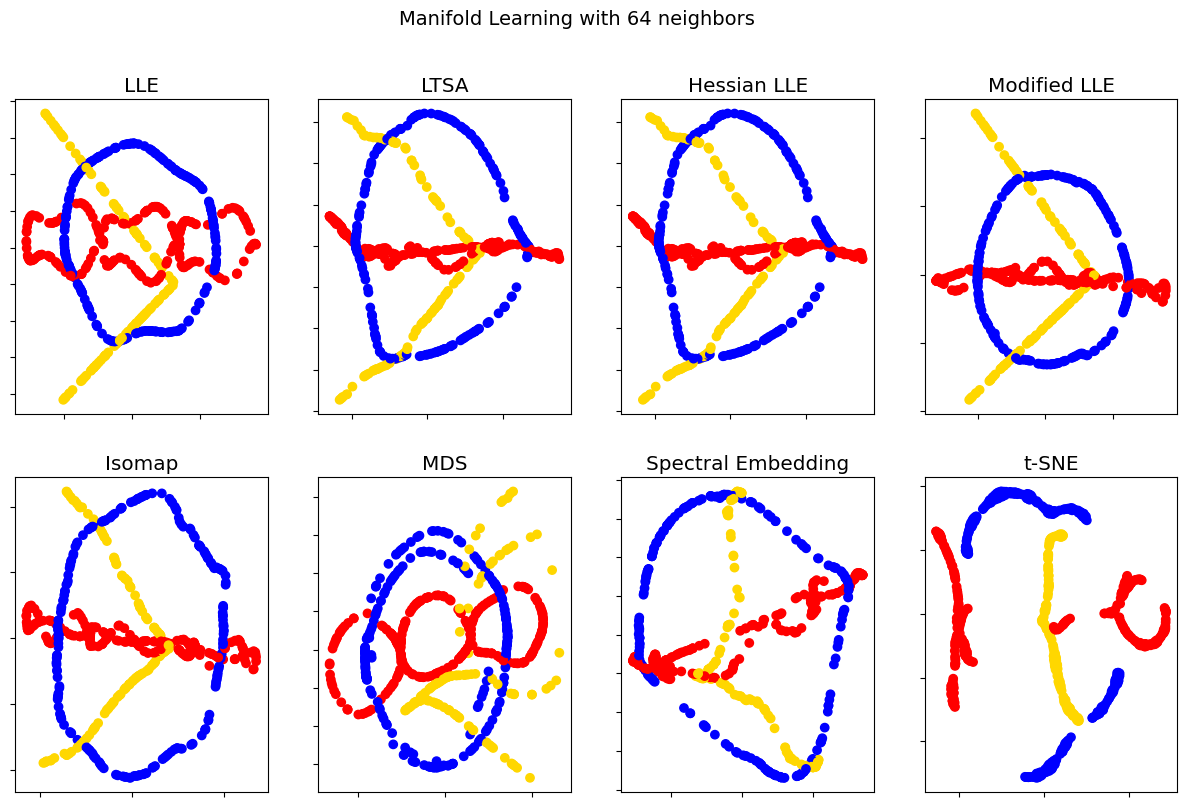

In [79]:
x0=np.loadtxt("DATA/x_notnoise_12d.dat", delimiter='\t')

neighbors_list = [10, 13, 16, 32, 64]
k = 1
for n in neighbors_list:
    Visual_maps(n, data = x0 ,vis_3D=k)
    k = 0

We are lookin at a method that separate correctly the dataset into the given clusters.

In particular we observe that the "*Spectral Embedding*" method perform quite well for the original dataset using less than 16 neighbors.